### Ce notebook va s'interresser a classifier les classes {claim, reference} vs {context} vs {claim, reference, context}

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)
	
# Data manipulation
import pandas as pd
import numpy as np
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from collections import Counter
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin

# Models fine tuning
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import make_scorer, f1_score
# Custom
import importlib
from utils.result_helper import save_result, display_result
import utils.helper as helper 

/mnt/c/Users/steve/Desktop/ML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.StepConfig = helper.ConfigLoader.load_step2()

In [4]:
df_path= "../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype("string")

df_base = df_base[df_base["science_related"] == 1]

classe = {
	(1,0) : 0,
	(0,1) : 1,
	(1,1) : 2,
}

df_base["claim_ref"] = df_base["scientific_claim"].combine_first(df_base["scientific_reference"]).astype(int)
df_base["scientific_context"] = df_base["scientific_context"].astype(int)
df_base["classe"] = df_base.apply(lambda row: classe.get((row["claim_ref"], row["scientific_context"]), None), axis=1)

df_base = df_base.drop(["science_related","scientific_claim","scientific_reference", "scientific_context", "claim_ref"], axis=1)

In [6]:
def dispay_df(df : DataFrame):
	return df.head().style.set_properties(
		subset=['text'],
		**{
			'text-align': 'left',
			'width': '600px',
			'white-space': 'normal'
		}
	)

In [7]:
dispay_df(df_base)

,text,classe
2,Can any Gynecologist with Cancer Experience explain the dangers of Transvaginal Douching with Fluoride or other toxins such as Dioxin? #PDX,0
3,Couch-lock highs lead to sleeping in the couch. Gotta stop doing this shit.,0
4,Does daily routine help prevent problems with bipolar disorder http://t.co/XGUfUDoLJB,0
6,“Traffic Jam” In Brain’s Neurons Could Be Cause Of Statin-Related Cognitive Decline http://t.co/kQ3XPdePKX,2
7,Can playing more games improve lives and save the world? by @chris_pelle via @PostArcade http://t.co/uEtVu099Ad #CDA30,0


# Maintenant on va définir les pre-processings

In [8]:
def word_length(X : DataFrame):
	tokenizer = TweetTokenizer()
	X["word_length"] =  X["text"].apply(lambda x: len(x) / len(tokenizer.tokenize(x)))
	return X

def numbers_processing(X: DataFrame) -> DataFrame:
	X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'\d+(\.\d+)?', 'NUM', x)).astype("string")
	return X

def uppercase_processing(X: DataFrame) -> DataFrame:
	X["uppercase_ratio"] = X["text"].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
	return X

def emoji_processing(X: DataFrame) -> DataFrame:
	def remove_emojis(text):
		return ''.join(char for char in text if char not in emoji.EMOJI_DATA)
	
	X["emoji_presence"] = X["text"].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x)).astype(int)
	X["text"] = X["text"].apply(remove_emojis).astype("string")
	return X

def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', 'url', text)
	
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link).astype("string")
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
	X["hashtag_count"] = X["text"].apply(lambda x: len(re.findall(r'#\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'#(\w+)', r'\1', x)).astype("string")
	return X

def mention_processing(X: DataFrame) -> DataFrame:
	X["mention_count"] = X["text"].apply(lambda x: len(re.findall(r'@\w+', x)))
	X["text"] = X["text"].apply(lambda x: re.sub(r'@(\w+)', "MENTION", x)).astype("string")
	return X


def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X["text"] = X["text"].apply(preprocess).astype("string")
	return X

In [9]:
df = df_base.copy()

df = word_length(df)
df = numbers_processing(df)
df = uppercase_processing(df)
df = emoji_processing(df)
df = link_processing(df)
df = hashtag_processing(df)
df = mention_processing(df)
df = pre_processing(df)

In [10]:
class KeywordFeatures(BaseEstimator, TransformerMixin):
	def __init__(self, n_keywords=10, verbose=False):
		self.verbose = verbose
		self.keyword_categories = {
			"context": [],
			"claim_ref": []
		}
		self.n_keywords = n_keywords
		self.regex_patterns = {}

	def _extract_category_keywords(self, text, category):
			return [word for word, pattern in self.regex_patterns[category].items() if pattern.search(text)]
	
	def _extract_top_keywords(self, text_series):
		"""
		Extrait les n mots les plus fréquents d'une série de textes.
		Le texte est supposé être déjà lemmatisé.
		"""
		combined_text = " ".join(text_series)
		tokens = re.findall(r'\b\w+\b', combined_text.lower())
		word_counts = Counter(tokens)
		filtered_counts = {word: count for word, count in word_counts.items() if len(word) >= 3}
		
		return [word for word, _ in Counter(filtered_counts).most_common(self.n_keywords * 2)]
	
	def fit(self, X: DataFrame, y:DataFrame):
		context_texts = X.loc[y == 1, 'text'].astype(str)
		claim_ref_texts = X.loc[y == 0, 'text'].astype(str)

		context_keywords = self._extract_top_keywords(context_texts)
		claim_ref_keywords = self._extract_top_keywords(claim_ref_texts)

		# on supprime les mots communs
		common_keywords = set(context_keywords) & set(claim_ref_keywords)
		context_keywords = [word for word in context_keywords if word not in common_keywords]
		claim_ref_keywords = [word for word in claim_ref_keywords if word not in common_keywords]

		self.keyword_categories["context"] = context_keywords[:self.n_keywords]
		self.keyword_categories["claim_ref"] = claim_ref_keywords[:self.n_keywords]

		self.regex_patterns = {
            category: {word: re.compile(r'\b' + word + r'\b', re.IGNORECASE) 
                      for word in words}
            for category, words in self.keyword_categories.items()
        }

		if self.verbose :
			print("Mots-clés science:", self.keyword_categories["science"])
			print("Mots-clés non-science:", self.keyword_categories["non_science"])

		return self

	def transform(self, X: DataFrame):
		X_transformed = X.copy()
		
		for category in self.keyword_categories:
			X_transformed[f"{category}_keyword_count"] = X["text"].apply(
				lambda x: len(self._extract_category_keywords(x, category))
			).astype(int)
		
		return X_transformed
	
	def fit_transform(self, X: DataFrame, y:DataFrame):
		self.fit(X, y)
		return self.transform(X)

In [11]:
X_bin = df.copy()
X_bin = X_bin[X_bin["classe"]  != 2]
y_bin = X_bin.pop("classe")

X_multi_label = df.copy()
y_multi_label = X_multi_label.pop("classe")

# Evaluation des classifiers avec 3 classes {context} vs {claim_ref} vs {both}

ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


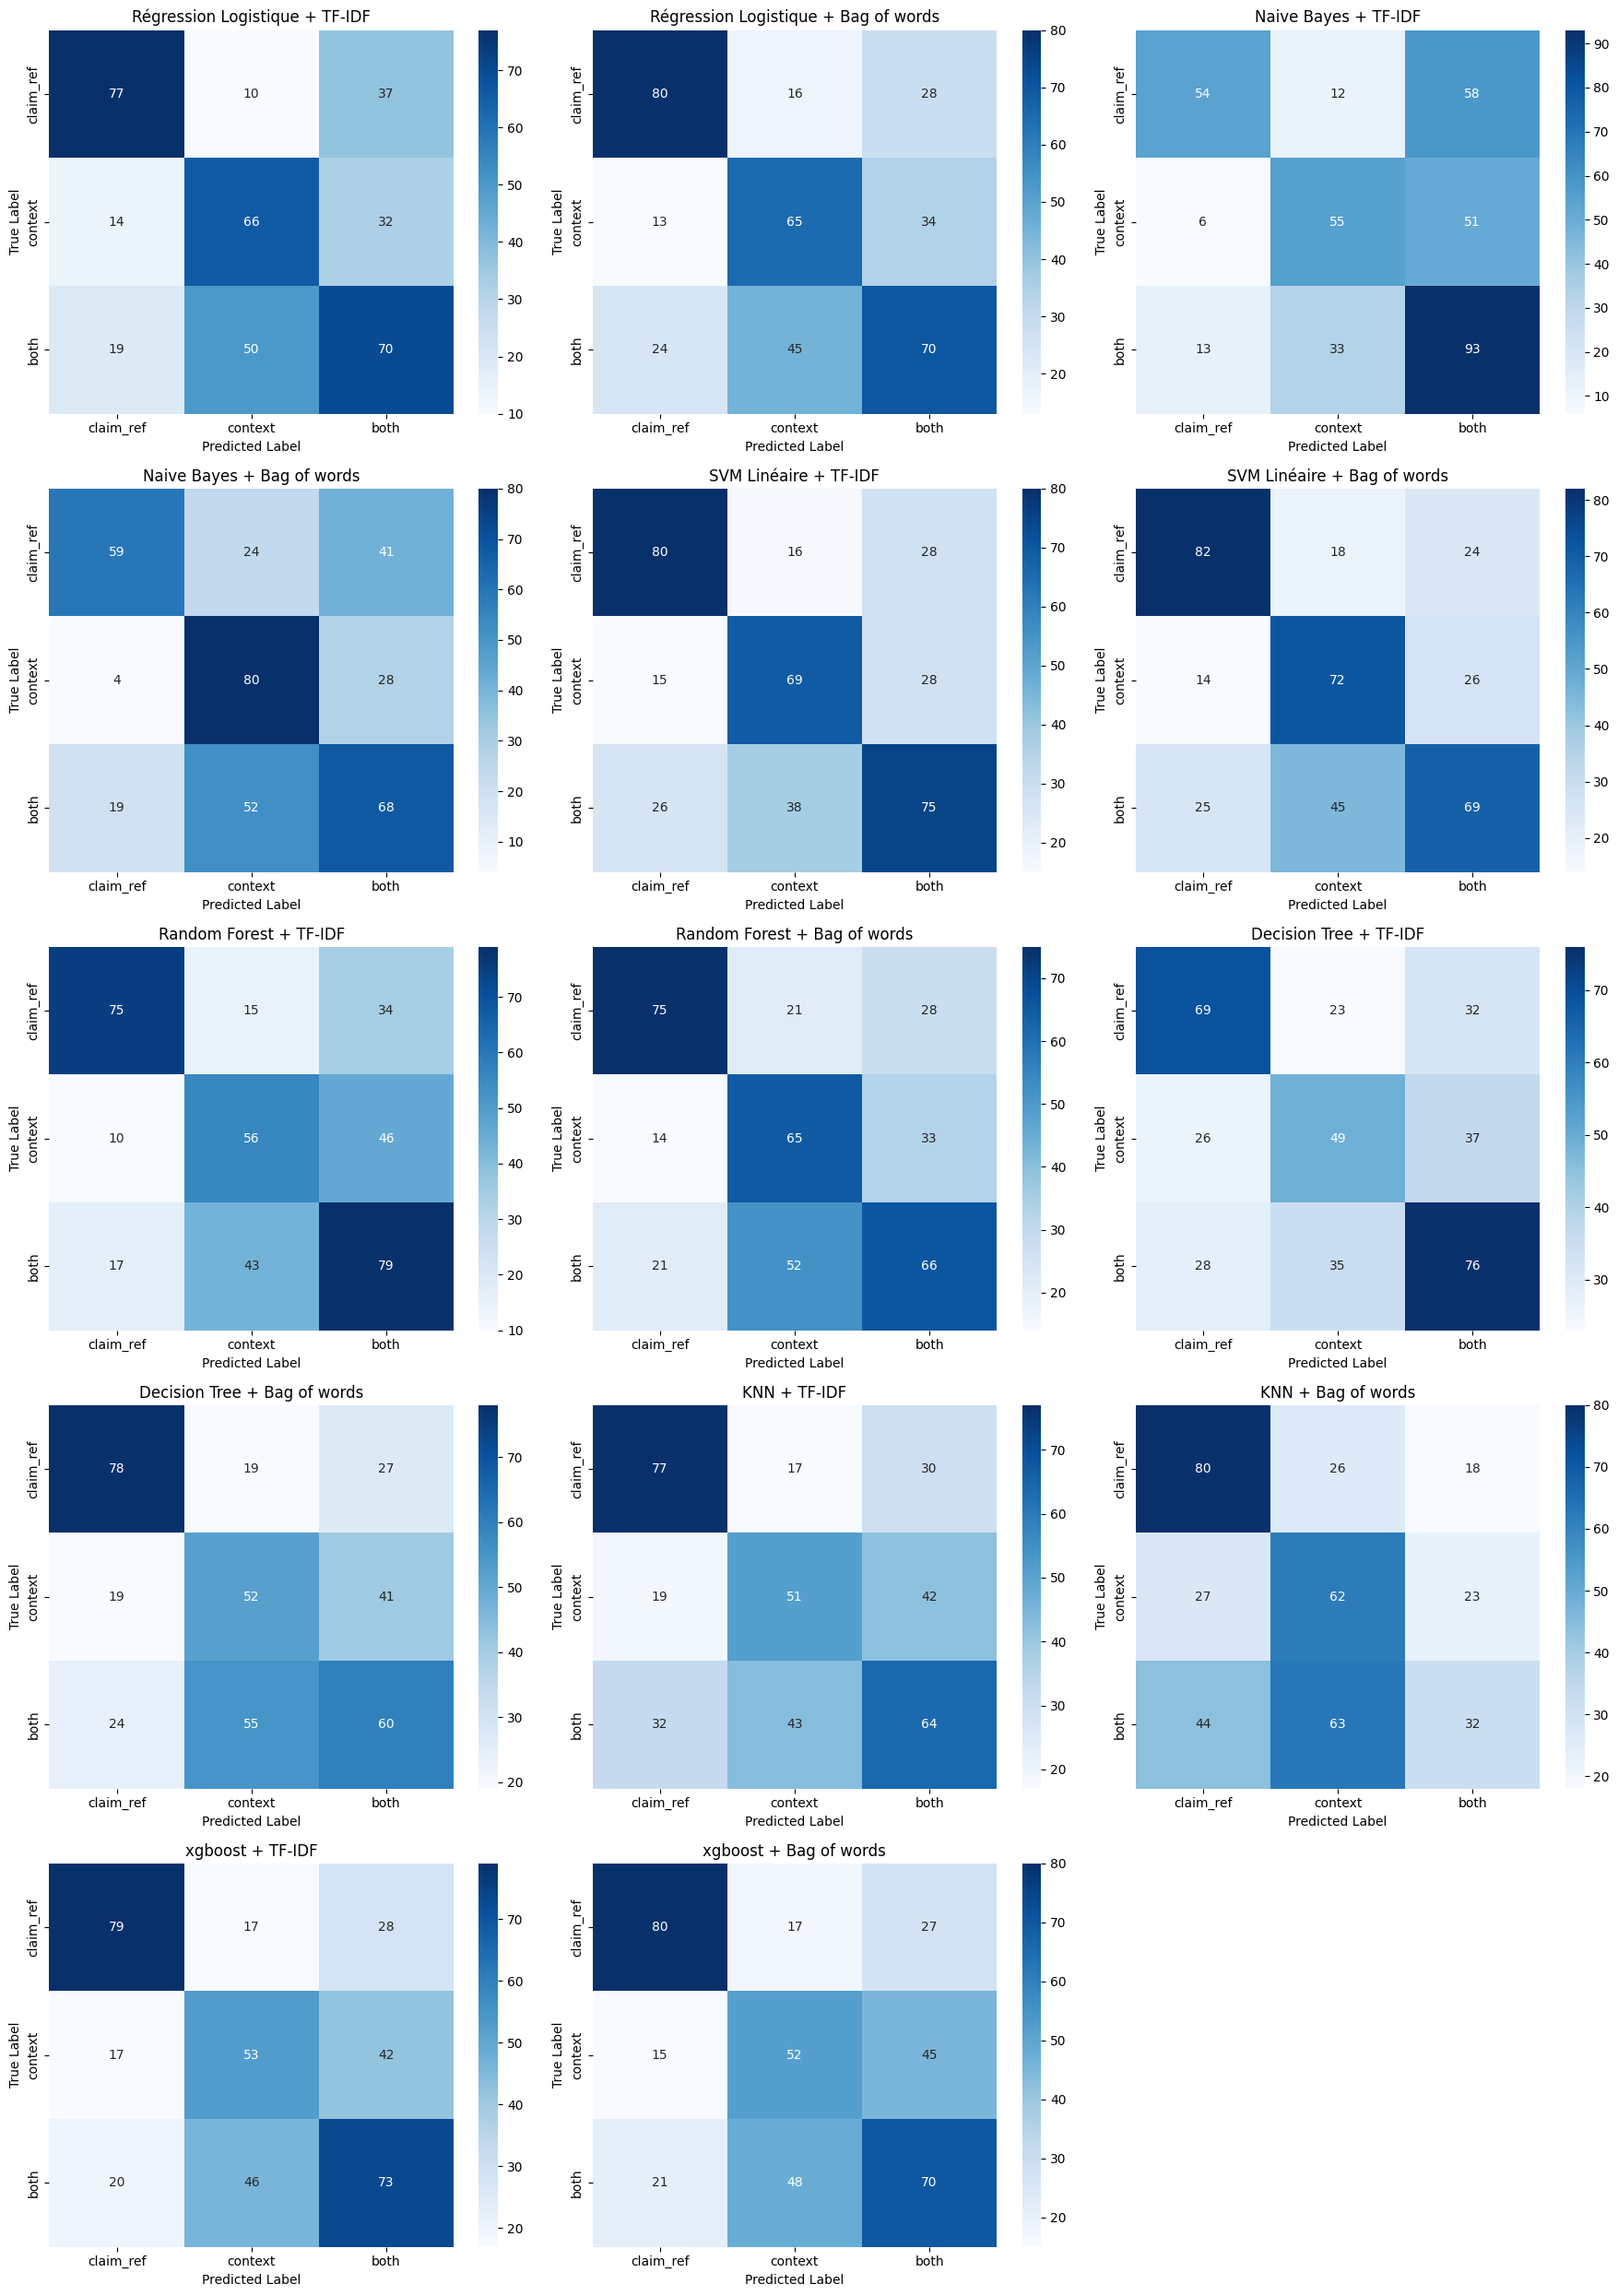

,Classifier,Vectorizer,F1 Mean,F1 Std
4,SVM Linéaire,TF-IDF,0.598,0.050
5,SVM Linéaire,Bag of words,0.594,0.041
1,Régression Logistique,Bag of words,0.573,0.053
0,Régression Logistique,TF-IDF,0.567,0.052
6,Random Forest,TF-IDF,0.562,0.044
3,Naive Bayes,Bag of words,0.551,0.082
7,Random Forest,Bag of words,0.550,0.038
12,xgboost,TF-IDF,0.546,0.055
13,xgboost,Bag of words,0.535,0.053
2,Naive Bayes,TF-IDF,0.531,0.089


In [12]:
import utils.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X_multi_label, y_multi_label, KeywordFeatures(15), config, ["claim_ref", "context", "both"])
results, classement_df = evaluator.evaluate()
classement_df.head(20)

# Evaluation des classifiers avec 2 classes {context} vs {claim_ref}

ℹ️  Evaluation de Régression Logistique avec TF-IDF
ℹ️  Evaluation de Régression Logistique avec Bag of words
ℹ️  Evaluation de Naive Bayes avec TF-IDF
ℹ️  Evaluation de Naive Bayes avec Bag of words
ℹ️  Evaluation de SVM Linéaire avec TF-IDF
ℹ️  Evaluation de SVM Linéaire avec Bag of words
ℹ️  Evaluation de Random Forest avec TF-IDF
ℹ️  Evaluation de Random Forest avec Bag of words
ℹ️  Evaluation de Decision Tree avec TF-IDF
ℹ️  Evaluation de Decision Tree avec Bag of words
ℹ️  Evaluation de KNN avec TF-IDF
ℹ️  Evaluation de KNN avec Bag of words
ℹ️  Evaluation de xgboost avec TF-IDF
ℹ️  Evaluation de xgboost avec Bag of words


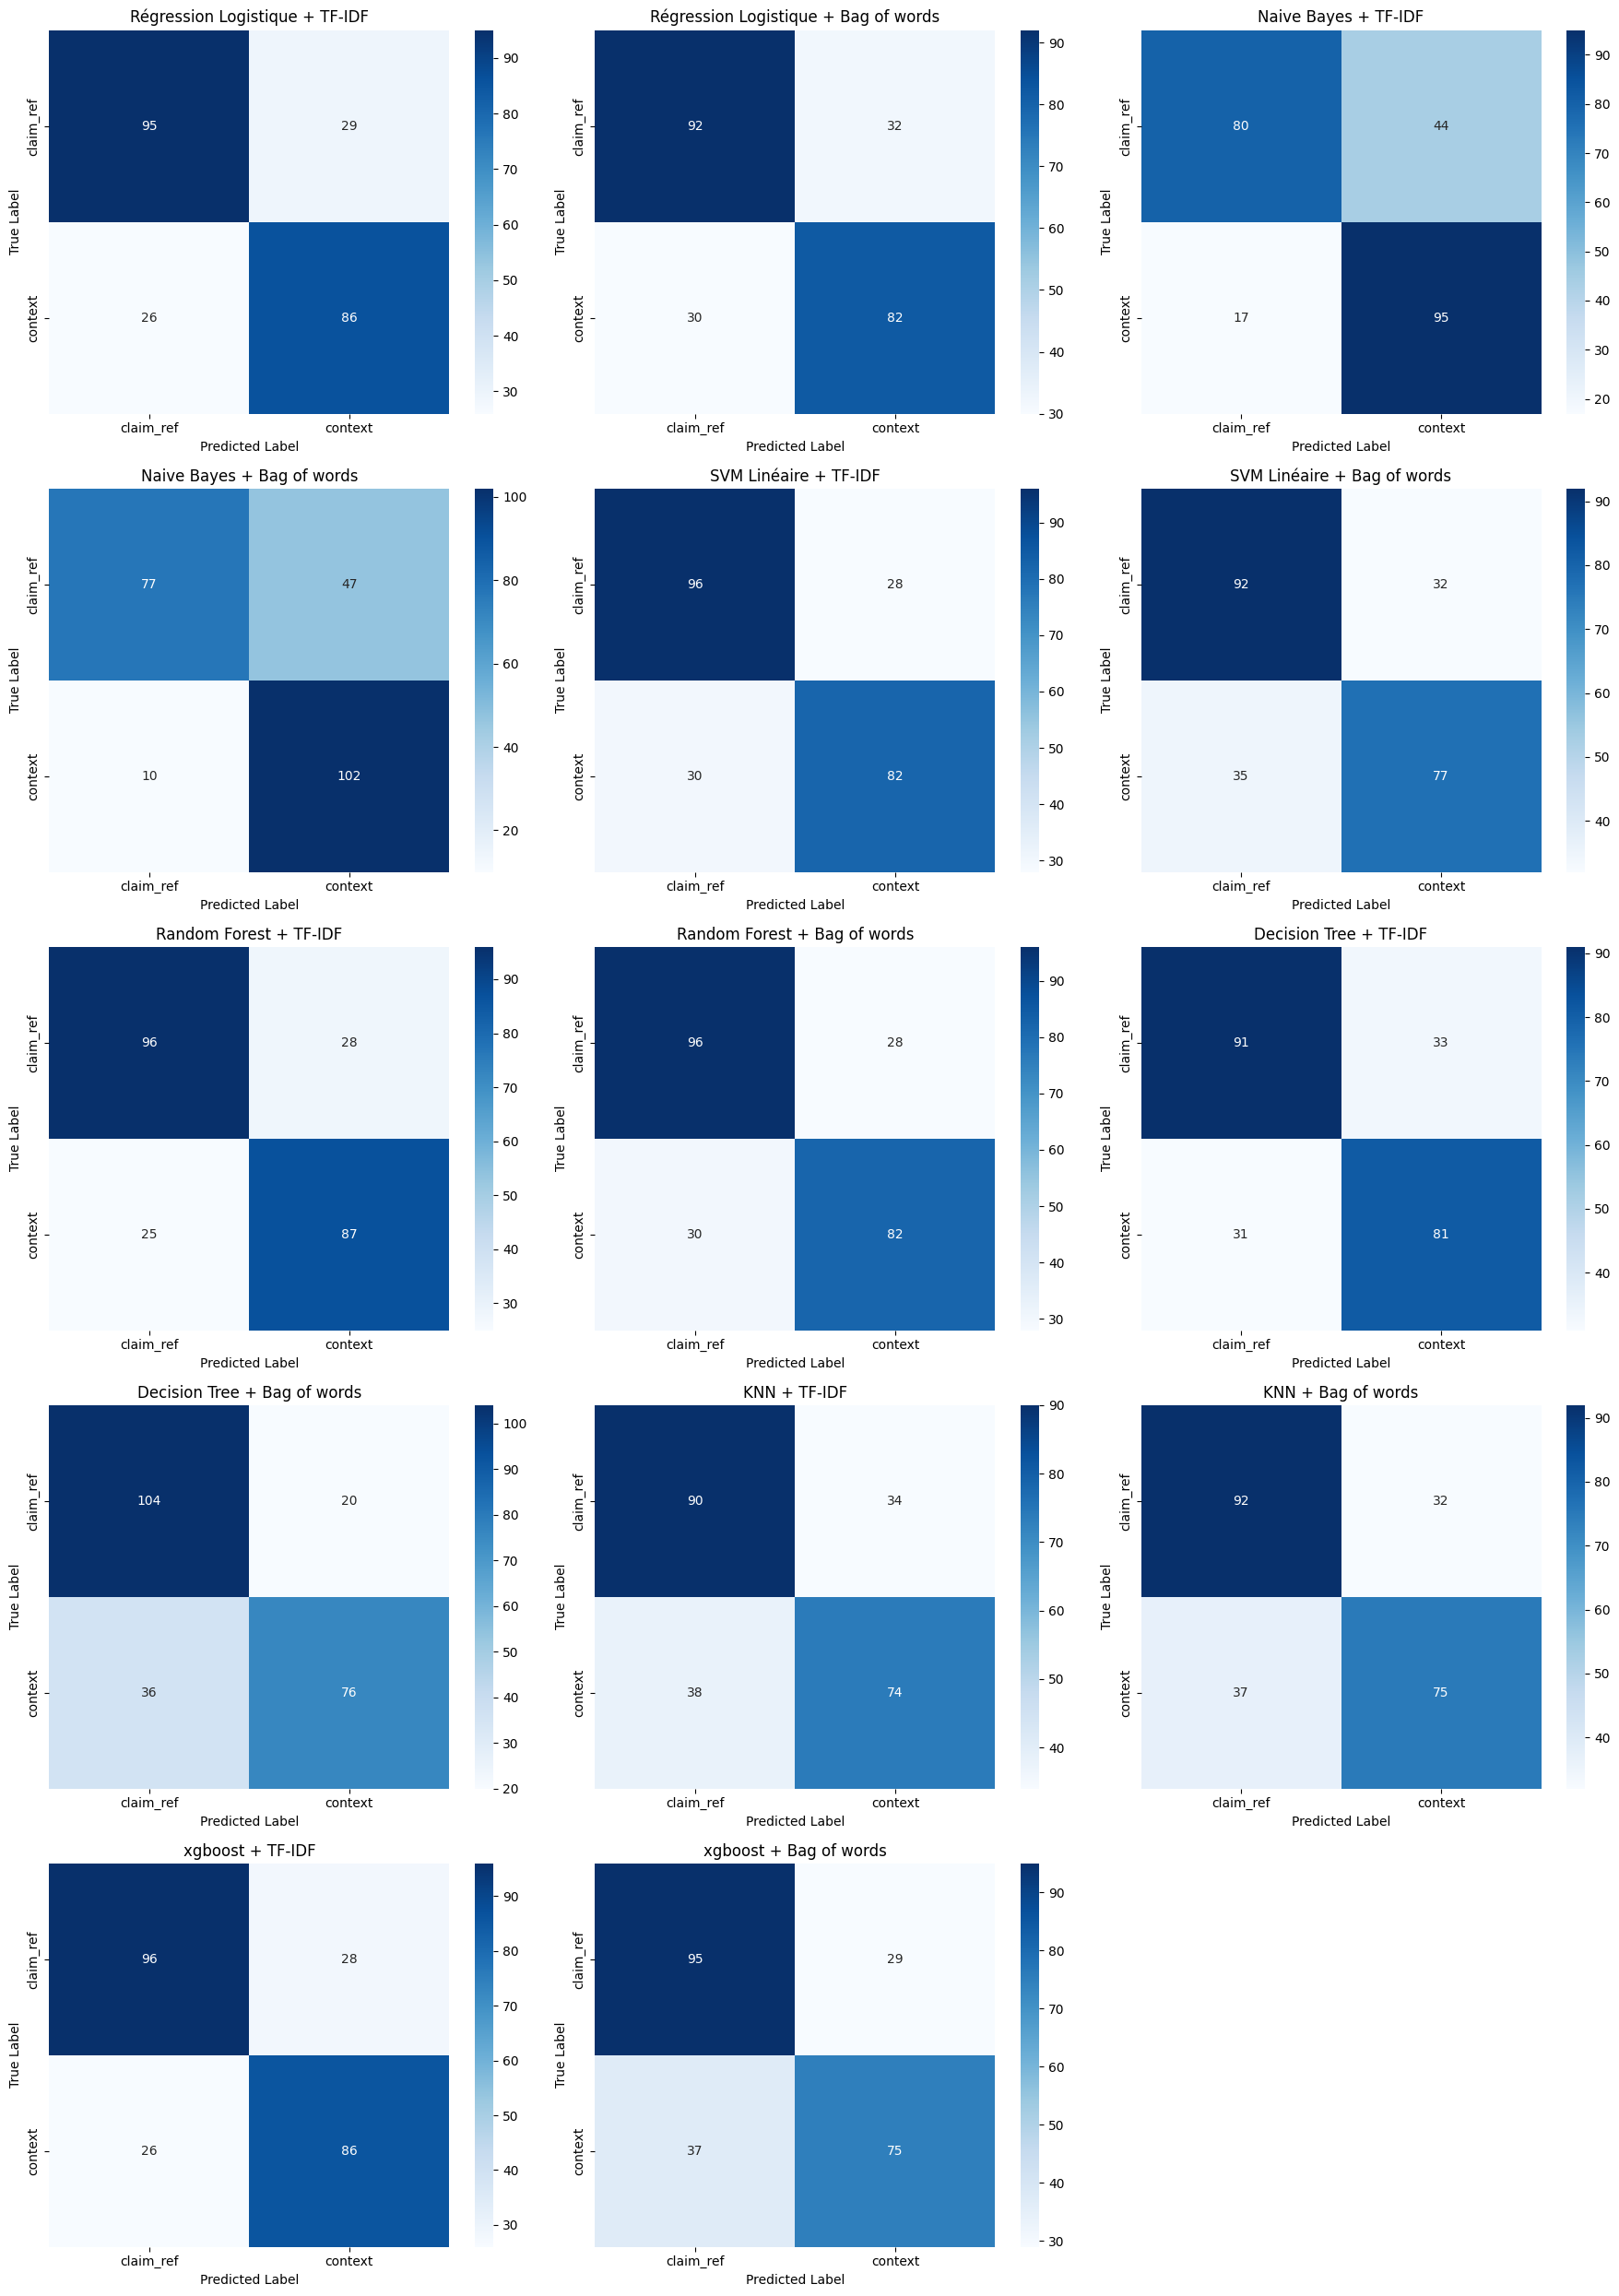

,Classifier,Vectorizer,F1 Mean,F1 Std
6,Random Forest,TF-IDF,0.774,0.036
12,xgboost,TF-IDF,0.768,0.059
0,Régression Logistique,TF-IDF,0.764,0.069
9,Decision Tree,Bag of words,0.757,0.066
3,Naive Bayes,Bag of words,0.753,0.066
7,Random Forest,Bag of words,0.750,0.040
4,SVM Linéaire,TF-IDF,0.748,0.119
2,Naive Bayes,TF-IDF,0.736,0.067
1,Régression Logistique,Bag of words,0.732,0.107
8,Decision Tree,TF-IDF,0.726,0.054


In [ ]:
importlib.reload(evaluation_classifiers)

xticks_label = ["claim_ref", "context"]
evaluator = evaluation_classifiers.ClassifierEvaluation(X_bin, y_bin, KeywordFeatures(15), config, xticks_label)
results, classement_df = evaluator.evaluate()
classement_df.head(20)

# Le choix des modèles et du type de problème (binary ou multi-labels)

## Le choix du type de problème

Comme nous pouvons le voir, les F1-score et leur std sont trés différents selon le type de problème,
C'est baseline nous expose qu'il est plus facile de faire en binaire qu'avec 3 classes

On peut voir que en moyenne nous sommes a 0.74 en binaire alors que nous sommes vers 0.54 avec les 3 classes

je choisis donc la méthode binaire, malgrés que je pers beaucoup de données. 

J'ai aussi choisit de ne pas gardé cette données et l'affecter dans une classe par défault (par example : context), car cela va polluer la classe par le bruit que cela va introduire.

## Le choix de mes Classifiers

1. xgboost & TF-IDF
2. Naive Bayes & TF-IDF
3. Régression Logistique & TF-IDF
4. Random Forest & TF-IDF

Ce choix est en rapport avec le classement, qui me montre clairement les capacités des modèles.

De plus, via mes connaissance personnnels je sais que certains modeles seront nettement plus performant avec de meilleurs hyper paramèttre. (Random Forest)

Je sais que mon dataset n'est pas classifiable linéairement, donc je sais que parmit les 4 modèles certains n'arriveront pas à s'améliorer drastiquement (XBoost, Régression Logistique, Naive Bayes)
Malgrès cela, je suis encore un étudiant, qui est novice, donc je préfère les inclures.

In [14]:
tickslabel = ["claim_ref","context"]
if config.is_multi_label():
	X = X_multi_label
	y = y_multi_label
	tickslabel = ["claim_ref","context", "both"]
	print("==== Classification multi-labels ====")
else:
	X = X_bin
	y = y_bin
	print("==== Classification binaire ====")


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)
X_train.head()

print(f"Nous avons {X_train.shape[0]} tweets d'entrainements et {X_test.shape[0]} de test")

==== Classification binaire ====
Nous avons 188 tweets d'entrainements et 48 de test


In [15]:
ngram_options = {
	"unigram": (1, 1),
	"bigram": (1, 2),
	"trigram": (1, 3),
	"quadrugram": (1, 4)
}
numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

text_col = "text"

In [16]:
def visualize_data_with_pca(X_test, y_test, pipeline, title="PCA des données", n_components = 2):
	"""
	Visualise les données transformées avec PCA et colore par classe
	"""
	# 1. Transformer les données avec le préprocesseur du pipeline
	preprocessor = pipeline.named_steps['preprocessor']
	X_transformed = preprocessor.transform(X_test)
	
	# Si la matrice est sparse, la convertir en dense
	if hasattr(X_transformed, "toarray"):
		X_dense = X_transformed.toarray()
	else:
		X_dense = X_transformed
	
	# 2. Appliquer PCA pour réduire à 2 dimensions
	pca = PCA(n_components=n_components)
	X_pca = pca.fit_transform(X_dense)
	
	# 3. Créer un DataFrame pour la visualisation
	df_plot = pd.DataFrame({
		'PC1': X_pca[:, 0],
		'PC2': X_pca[:, 1],
		'Class': y_test.values
	})
	
	# 4. Visualiser avec un scatter plot
	plt.figure(figsize=(10, 8))
	sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Class', 
				   palette={0: "red", 1: "blue"},s=60)
	
	# 5. Ajouter des informations sur la variance expliquée
	explained_var = pca.explained_variance_ratio_
	plt.xlabel(f'PC1 ({explained_var[0]:.2%} variance expliquée)')
	plt.ylabel(f'PC2 ({explained_var[1]:.2%} variance expliquée)')
	plt.title(f'{title}\nVariance totale expliquée: {sum(explained_var):.2%}')
	
	# 6. Ajouter une légende
	plt.legend(title="Classe", labels=["Non-scientifique", "Scientifique"])
	
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.plot()

	return X_pca

from sklearn.utils import resample

def get_score(pipeline, n_iterations=100):
    f1_scores = []
    
    for i in range(n_iterations):
        indices = resample(range(len(X_test)), replace=True, n_samples=len(X_test))
        X_boot = X_test.iloc[indices] if hasattr(X_test, 'iloc') else X_test[indices]
        y_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]

        y_pred = pipeline.predict(X_boot)
        f1 = f1_score(y_boot, y_pred, average='macro')
        f1_scores.append(f1)
    
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    print(f"✅ F1-score (bootstrap sur test, {n_iterations} itérations): {f1_mean:.3f} ± {f1_std:.3f}")
    return f1_mean, f1_std

def get_vectorizer(vectorizer_type, ngram_key, min_df, max_features):
	if vectorizer_type == "tfidf":
		return TfidfVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)
	return CountVectorizer(
			ngram_range=ngram_options[ngram_key],
			min_df=min_df,
			max_features=max_features
		)

def get_trial_score(classifier, vectorizer, n_keywords, scaling = True):
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, "text"),
			("num", StandardScaler() if scaling else "passthrough", numerical_cols)
		]
	)
	
	pipeline = Pipeline([
		("keywords", KeywordFeatures(n_keywords)),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

	kfold = KFold(n_splits=3, shuffle=True, random_state=config.random_state)
	return  cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()


def get_pipeline(model, classifier, scaler = True):
	vectorizer = model.get_vectorizer()
	numerical_cols = X_train.select_dtypes(include='number').columns.tolist()

	
	preprocessor = ColumnTransformer(
		transformers=[
			("text", vectorizer, text_col),
			("num", StandardScaler() if scaler else "passthrough", numerical_cols)
		]
	)

	return Pipeline([
		("keywords", KeywordFeatures(model.get_config("n_keywords"))),
		("preprocessor", preprocessor),
		("classifier", classifier)
	])

#### XBoost

In [17]:
def objective(trial):
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 3, 10)
	learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
	subsample = trial.suggest_float("subsample", 0.5, 1.0)
	colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
	gamma = trial.suggest_float("gamma", 0, 5)
	reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
	reg_lambda = trial.suggest_float("reg_lambda", 0, 10)
	
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	
	classifier = XGBClassifier(
			n_estimators=n_estimators,
			max_depth=max_depth,
			learning_rate=learning_rate,
			subsample=subsample,
			colsample_bytree=colsample_bytree,
			gamma=gamma,
			reg_alpha=reg_alpha,
			reg_lambda=reg_lambda,
			eval_metric="logloss",
			random_state=config.random_state
		)
	
	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:42:35,821] A new study created in memory with name: no-name-062da50e-74af-4329-bf2e-bfb1de8bab5a


In [18]:
study.optimize(objective, n_trials=100)

print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("XBoost", study.best_params)

[I 2025-05-06 19:42:39,259] Trial 0 finished with value: 0.6985395830223416 and parameters: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.08947952299741382, 'subsample': 0.9170401408828386, 'colsample_bytree': 0.8630895320350798, 'gamma': 0.2803179918170007, 'reg_alpha': 4.77624627668567, 'reg_lambda': 0.40744915162686524, 'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 5, 'max_features': 10000, 'n_keywords': 25}. Best is trial 0 with value: 0.6985395830223416.
[I 2025-05-06 19:42:40,189] Trial 1 finished with value: 0.6730544881295034 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.038747977892762624, 'subsample': 0.8388855646050657, 'colsample_bytree': 0.5251616151865803, 'gamma': 2.978335607623088, 'reg_alpha': 3.5879458100177883, 'reg_lambda': 2.8598681033975715, 'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 9, 'max_features': 15000, 'n_keywords': 10}. Best is trial 0 with value: 0.6985395830223416.
[I 2025-05-06

Best f1_macro: 0.7475583932890272
Best params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.16337785390832182, 'subsample': 0.9470410584430072, 'colsample_bytree': 0.9790991722836205, 'gamma': 0.6426327231855744, 'reg_alpha': 0.6360504191787868, 'reg_lambda': 3.827988954997142, 'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 4, 'max_features': 16000, 'n_keywords': 25}
✅  Model (XBoost) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.683 ± 0.070


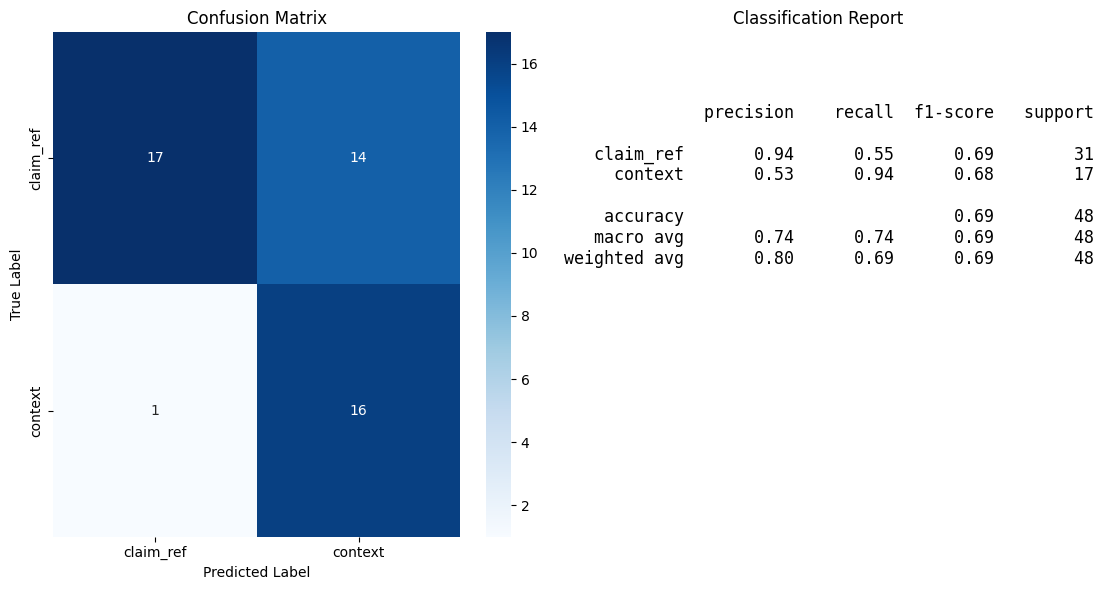

✅ Results saved to: ../results/Step2/Binary/XBoost


In [44]:
model = config.get_model("XBoost")
classifier = XGBClassifier(
			n_estimators= model.get_config("n_estimators"),
			max_depth= model.get_config("max_depth"),
			learning_rate= model.get_config("learning_rate"),
			subsample= model.get_config("subsample"),
			colsample_bytree= model.get_config("colsample_bytree"),
			gamma= model.get_config("gamma"),
			reg_alpha= model.get_config("reg_alpha"),
			reg_lambda= model.get_config("reg_lambda"),
			eval_metric="logloss",
			random_state=config.random_state
		)

pipeline_XBoost = get_pipeline(model, classifier, scaler=False)

pipeline_XBoost.fit(X_train, y_train)
y_pred = pipeline_XBoost.predict(X_test)

f1_m, f1_std = get_score(pipeline_XBoost)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

#### Naive Bayes

In [20]:
def objective(trial):
	alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)

	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["bow"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)
	
	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(MultinomialNB(alpha=alpha), vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:45:19,346] A new study created in memory with name: no-name-72d73bd0-573e-43b6-b618-88b86971e016


In [22]:
study.optimize(objective, n_trials=50)
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("NB", study.best_params)

[I 2025-05-06 19:45:42,113] Trial 50 finished with value: 0.7625487426005114 and parameters: {'alpha': 0.4484431652529053, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 4, 'max_features': 8000, 'n_keywords': 15}. Best is trial 43 with value: 0.7911214792287931.
[I 2025-05-06 19:45:42,363] Trial 51 finished with value: 0.7858544754738862 and parameters: {'alpha': 0.10787683763737509, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 4, 'max_features': 10000, 'n_keywords': 25}. Best is trial 43 with value: 0.7911214792287931.
[I 2025-05-06 19:45:42,604] Trial 52 finished with value: 0.7539906657690302 and parameters: {'alpha': 0.0010847812612802214, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 3, 'max_features': 6000, 'n_keywords': 30}. Best is trial 43 with value: 0.7911214792287931.
[I 2025-05-06 19:45:42,847] Trial 53 finished with value: 0.7911214792287931 and parameters: {'alpha': 0.15802865331463717, 'vectorizer_type': 'bow', 'ngram_rang

Best f1_macro: 0.7911214792287931
Best params: {'alpha': 0.17693559340924833, 'vectorizer_type': 'bow', 'ngram_range': 'trigram', 'min_df': 4, 'max_features': 6000, 'n_keywords': 20}
✅  Model (NB) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.720 ± 0.075


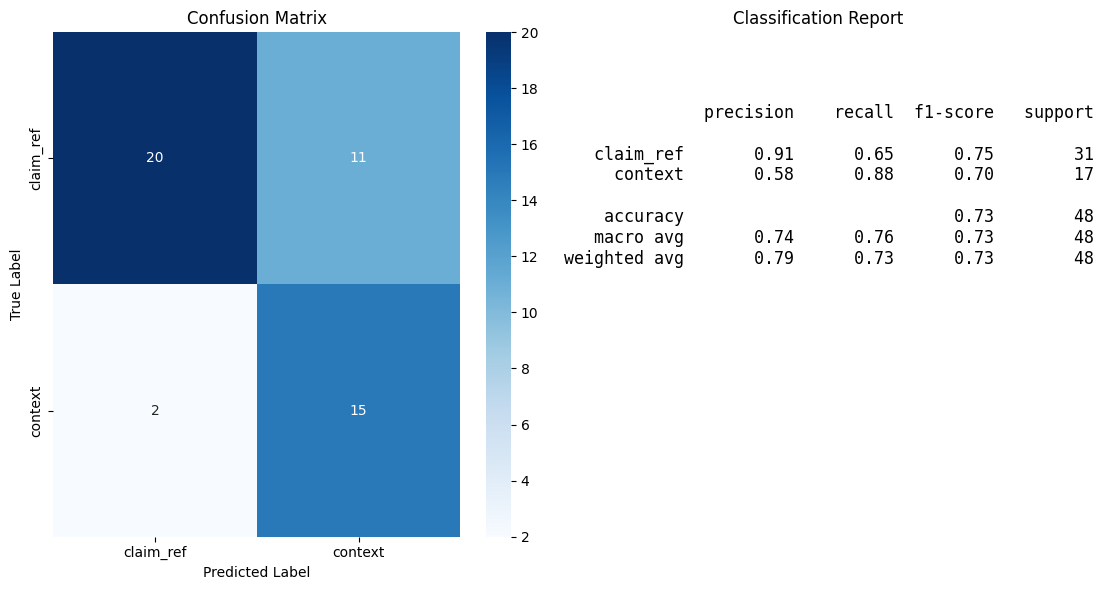

✅ Results saved to: ../results/Step2/Binary/NB


In [43]:
model = config.get_model("NB")
classifier = MultinomialNB(alpha = model.get_config("alpha"))

pipeline_NB = get_pipeline(model, classifier, scaler=False)

pipeline_NB.fit(X_train, y_train)
y_pred = pipeline_NB.predict(X_test)

f1_m, f1_std = get_score(pipeline_NB)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

#### Régression Logistique

In [25]:
def objective(trial):
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	n_keywords = trial.suggest_int("n_keywords", 0, 30, step=5)
	
	# Hyperparamètres Logistic Regression
	C = trial.suggest_float("C", 1e-4, 100.0, log=True)
	penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
	solver = trial.suggest_categorical("solver", ["liblinear", "saga"])

	if penalty == "l1" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()

	if penalty == "l2" and solver not in ["liblinear", "saga"]:
		raise optuna.exceptions.TrialPruned()
	

	classifier = LogisticRegression(
		C=C,
		penalty=penalty,
		solver=solver,
		random_state=config.random_state,
		class_weight='balanced',
		max_iter=8000
	)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=True)

study = optuna.create_study(direction="maximize")

[I 2025-05-06 19:47:13,799] A new study created in memory with name: no-name-a495e0dd-6234-4efe-a358-8a083f94e474


In [28]:
study.optimize(objective, n_trials=50)
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)

config.save_model("Regression Logistique", study.best_params)

[I 2025-05-06 19:48:56,866] Trial 100 finished with value: 0.8057098765432098 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 1, 'max_features': 20000, 'n_keywords': 25, 'C': 9.767956380409927, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 84 with value: 0.817795462034621.
/mnt/c/Users/steve/Desktop/ML/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2025-05-06 19:48:59,297] Trial 101 finished with value: 0.7774136949343721 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 1, 'max_features': 20000, 'n_keywords': 25, 'C': 11.440414220239397, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 84 with value: 0.817795462034621.
[I 2025-05-06 19:48:59,532] Trial 102 finished with value: 0.7949074074074073 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'trigram', 'min_df': 1, 'max_features

Best f1_macro: 0.823240806477303
Best params: {'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 2, 'max_features': 13000, 'n_keywords': 0, 'C': 70.73605883987985, 'penalty': 'l1', 'solver': 'liblinear'}
✅  Model (Regression Logistique) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.766 ± 0.060


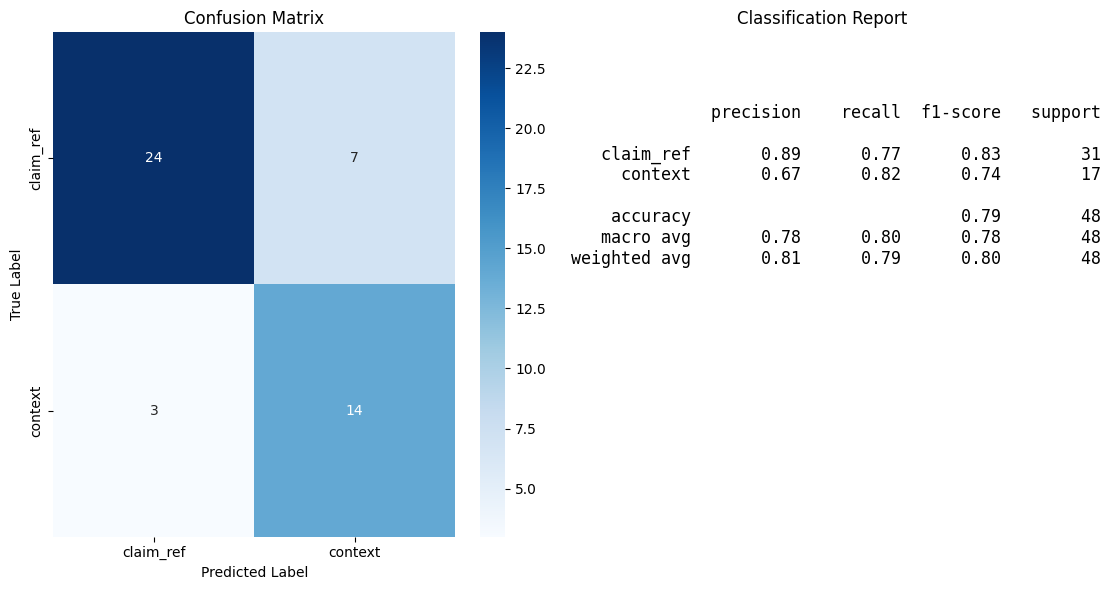

✅ Results saved to: ../results/Step2/Binary/Regression Logistique


In [42]:
model = config.get_model("Regression Logistique")
classifier = LogisticRegression(
        C = model.get_config("C"),
		penalty = model.get_config("penalty"),
        solver = model.get_config("solver"),
        class_weight = "balanced",
        random_state = config.random_state,
        max_iter = 8000
    )

pipeline_RL = get_pipeline(model, classifier)

pipeline_RL.fit(X_train, y_train)
y_pred = pipeline_RL.predict(X_test)

f1_m, f1_std = get_score(pipeline_RL)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)

#### Random Forest

In [32]:
def objective(trial):

	# Hyperparamètres texte
	vectorizer_type = trial.suggest_categorical("vectorizer_type", ["tfidf"])
	ngram_key = trial.suggest_categorical("ngram_range", list(ngram_options.keys()))
	min_df = trial.suggest_int("min_df", 1, 10)
	max_features = trial.suggest_int("max_features", 1000, 20000, step=1000)

	# Hyperparamètres Random Forest
	n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
	max_depth = trial.suggest_int("max_depth", 5, 50)
	min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
	min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)

	bootstrap = trial.suggest_categorical("bootstrap", [True, False])
	max_features_model = trial.suggest_categorical("max_features_model", ['sqrt', 'log2', None])

	n_keywords = trial.suggest_int("n_keywords", 10, 30, step=5)


	classifier = RandomForestClassifier(
		n_estimators=n_estimators,
		max_depth=max_depth,
		min_samples_split=min_samples_split,
		min_samples_leaf=min_samples_leaf,
		random_state=config.random_state,
		max_features= max_features_model,
		bootstrap = bootstrap,
		class_weight='balanced'
	)

	vectorizer = get_vectorizer(vectorizer_type, ngram_key, min_df, max_features)
	return get_trial_score(classifier, vectorizer, n_keywords, scaling=False)

study = optuna.create_study(direction="maximize")


[I 2025-05-06 19:51:47,792] A new study created in memory with name: no-name-476b41d0-9b00-4bcb-951f-1bc9ad673d93


In [33]:
study.optimize(objective, n_trials=100)
print("✅ Best f1_macro:", study.best_value)
print("✅ Best params:", study.best_params)
config.save_model("RandomForest", study.best_params)

[I 2025-05-06 19:52:00,676] Trial 0 finished with value: 0.7654875980389934 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 1, 'max_features': 19000, 'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features_model': None, 'n_keywords': 10}. Best is trial 0 with value: 0.7654875980389934.
[I 2025-05-06 19:52:02,550] Trial 1 finished with value: 0.785426577420405 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'bigram', 'min_df': 6, 'max_features': 5000, 'n_estimators': 500, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features_model': 'sqrt', 'n_keywords': 10}. Best is trial 1 with value: 0.785426577420405.
[I 2025-05-06 19:52:12,360] Trial 2 finished with value: 0.7472612116947093 and parameters: {'vectorizer_type': 'tfidf', 'ngram_range': 'quadrugram', 'min_df': 1, 'max_features': 1000, 'n_estimators': 1000, 'max_depth': 10, 'min_samples

✅ Best f1_macro: 0.7956192751891678
✅ Best params: {'vectorizer_type': 'tfidf', 'ngram_range': 'unigram', 'min_df': 6, 'max_features': 8000, 'n_estimators': 800, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features_model': 'sqrt', 'n_keywords': 10}
✅  Model (RandomForest) saved in config file


✅ F1-score (bootstrap sur test, 100 itérations): 0.741 ± 0.075


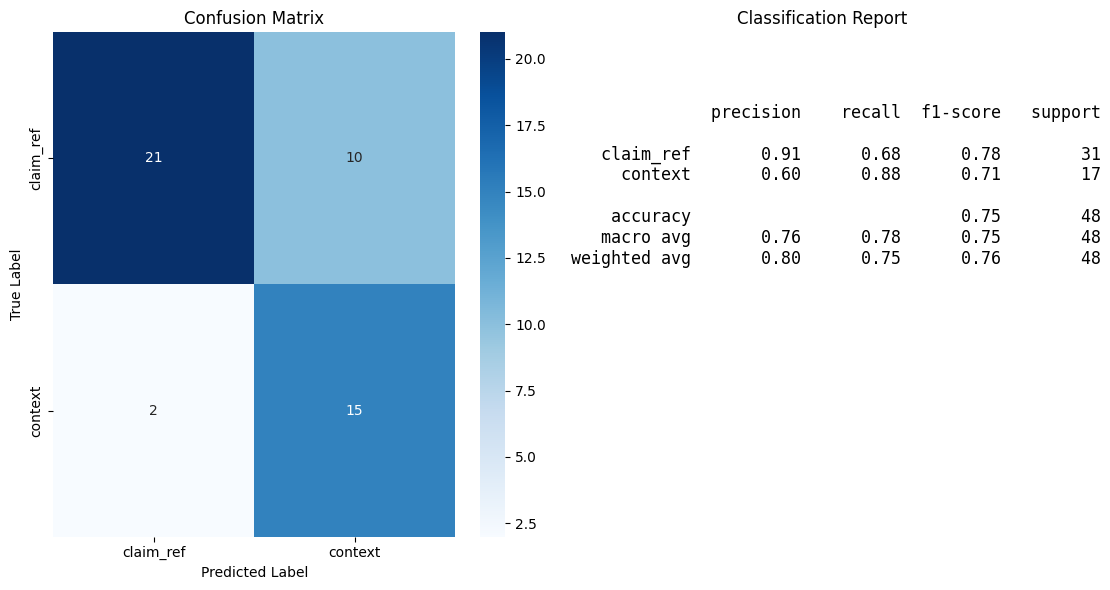

✅ Results saved to: ../results/Step2/Binary/RandomForest


In [45]:
model = config.get_model("RandomForest")
classifier = RandomForestClassifier(
		n_estimators = model.get_config("n_estimators"),
		max_depth = model.get_config("max_depth"),
		min_samples_split = model.get_config("min_samples_split"),
		min_samples_leaf = model.get_config("min_samples_leaf"),
		bootstrap = model.get_config("bootstrap"),
		max_features = model.get_config("max_features_model"),
		random_state = config.random_state,
		class_weight='balanced'
	)

pipeline_RF = get_pipeline(model, classifier, scaler=False)

pipeline_RF.fit(X_train, y_train)
y_pred = pipeline_RF.predict(X_test)

f1_m, f1_std = get_score(pipeline_RF)
fig = display_result(y_pred, y_test, xticks_label)

save_result(
	title=f"Rapport du {model.name}",
    description= f"Ce graphique montre le résultats hyperparamètrique avec optuna\n ## Résultat : {f1_m:0.3f}±{f1_std:0.3f}",
    fig=fig,
	output_dir = os.path.join(config.result_dir, config.step_name, config.get_type(), model.name),
	static_dir = config.static_dir
)